In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns
import holidays
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

## 0 - Cargar de datos y revisión General

- Revisar primeras y ultimas filas del dataframe.
- Cuantas filas/columnas componen el df.
- Revisar el tipo de varaibles.
- Revisar columnas con valores - Revisar las filas/columnas duplicadas. No queremos redundancia ni tampoco tener la misma instancia en el conjunto de entrenamiento y test.
- Describe y revisar que los valores tengan sentido.


In [2]:
#Cargamos el dataframe
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
df = pd.read_csv(url)  
df.to_csv("/workspaces/Jacinto-Proyecto-procesamiento-datos/AB_NYC_2019_temp.csv", index=False)

#Revisamos las primeras filas del dataframe
df.head() 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
#Revisamos las ultimas filas del dataframe
df.tail() 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [4]:
#Vemos las dimensiones en filas y columnas del dataframe
df.shape

(48895, 16)

In [5]:
#Vemos un resumen detallado del dataframe para conocer el tipo de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
#Observamos los valores unicos de cada columna del df
n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [7]:
# Identificar columnas con un solo valor único
cols_constantes = df.nunique()[df.nunique() == 1].index

# Eliminar estas columnas del DataFrame
df = df.drop(columns=cols_constantes)

print(f"Columnas eliminadas: {list(cols_constantes)}")

Columnas eliminadas: []


No existen columnas con valores constantes

In [8]:
# Comprobar la presencia de filas duplicadas
df.duplicated().sum()

np.int64(0)

No existen celdas duplicadas

In [9]:
#Cambiamos filas por columnas y vemos si hay valores duplicados
df.T.duplicated(keep=False)


id                                False
name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

No hay valores duplicados en nuestras filas.

## 1.Distribución de las variables y relación entre variables.

Además de histogramas, boxplots y scatterplots considerar diferentes técnicas de codificación de variables categóricas (one-hot encoding, target encoding, frecuency encoding, label encoder...).

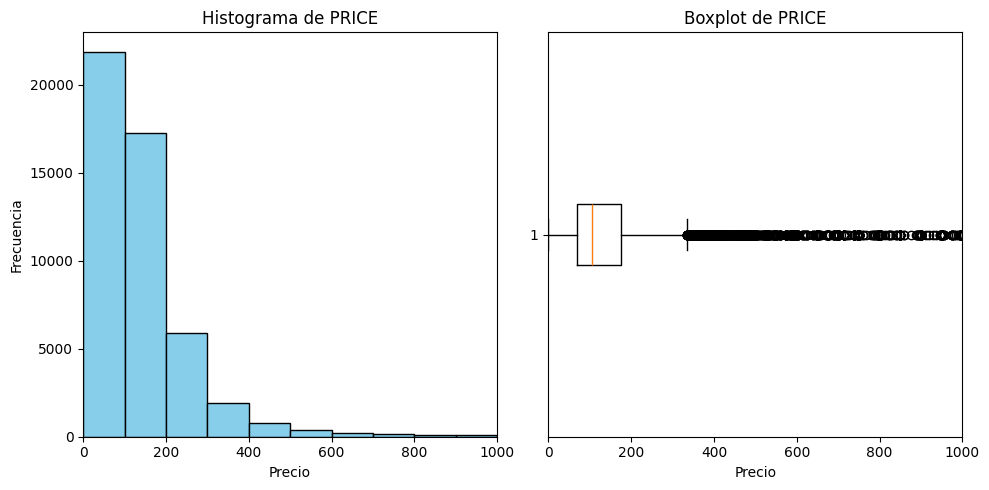

In [10]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins=100, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlim(0, 1000)  # Fijamos el límite máximo en el eje X

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de PRICE')
ax[1].set_xlabel('Precio')
ax[1].set_xlim(0, 1000)  # Fijamos el límite máximo en el eje X

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

### EXPLICACIÓN DE LAS GRÁFICAS:
1-Histograma de price

La mayoría de los valores se concentran en el extremo izquierdo del gráfico, lo que sugiere una alta cantidad de alojamientos con precios bajos.

Si observamos una cola larga hacia la derecha, esto indica la presencia de alojamientos de lujo con precios muy elevados.

La asimetría en la distribución podría indicar una distribución sesgada, lo que podría afectar modelos de regresión o análisis estadísticos.

2-Boxplot de PRICE

La línea dentro de la caja representa la mediana, que es el precio medio de los alojamientos.

Los bordes de la caja indican el rango intercuartil (percentiles 25 y 75), mostrando la mayoría de los precios típicos.

Los puntos fuera de los bigotes son alojamientos con precios significativamente más altos que la mayoría.

Si el boxplot tiene bigotes muy extendidos, indica que hay una amplia variabilidad en los precios.

- Creamos la columna LOG_PRICE, que representa el precio (price) transformado con una función logarítmica. La razón principal para hacer esto es reducir la influencia de valores extremos y hacer que la distribución de precios sea más manejable para la regresión y otros análisis estadísticos.

In [11]:
#Creamos la columna Log_Price
df.loc[:, 'LOG_PRICE'] = np.log(df['price'] + 1)  # Evita problemas con log(0)

df = df[df['price'] > 0]  # Filtra valores cero antes de calcular el log
df.loc[:, 'LOG_PRICE'] = np.log(df['price'])

print(df['price'].describe())  # Revisa mínimos y posibles valores incorrectos

df['LOG_PRICE'] = np.where(df['price'] > 0, np.log(df['price']), 0)

count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


- Hacemos 2 graficas (Histograma y boxplot) de log_price para verificar si la distribución es más simetrica.

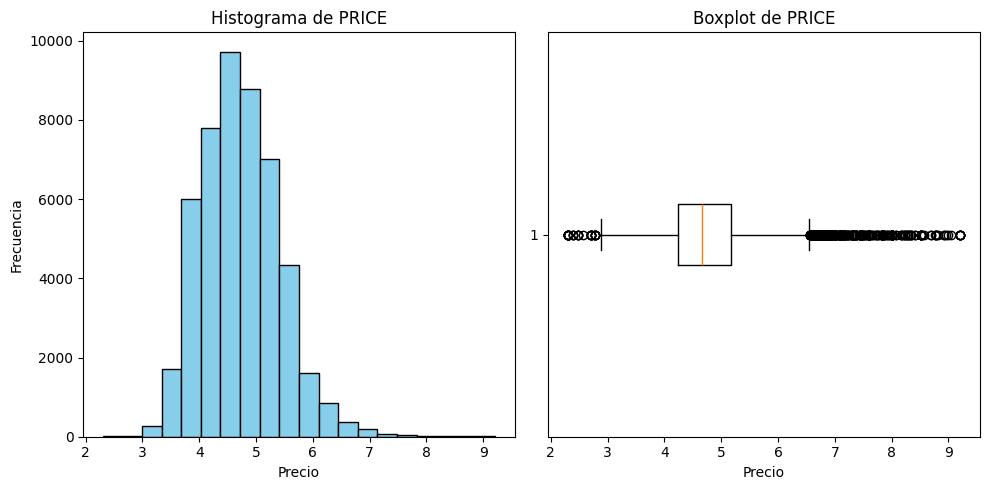

In [12]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['LOG_PRICE'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['LOG_PRICE'], vert=False)
ax[1].set_title('Boxplot de PRICE')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

EXPLICACIÓN DE LAS GRÁFICAS:

1-Histograma de log_price
Este gráfico muestra la distribución de los precios de los alojamientos. Observaciones clave:

- La mayoría de los precios están concentrados en un rango bajo, lo que indica que hay muchos alojamientos económicos.

- Hay un sesgo a la derecha (valores altos en el extremo derecho), lo que sugiere que existen algunos alojamientos con precios excepcionalmente elevados.

- La cantidad de bins (bins=100) da una alta resolución en la visualización, ayudando a ver mejor la concentración de los valores.

2-Boxplot de log_price
El boxplot representa la dispersión y presencia de valores atípicos:

- La caja central muestra el rango intercuartílico (Q1-Q3) de los precios.

- La línea dentro de la caja representa la mediana.

- Valores atípicos: Se observan puntos fuera de los "bigotes", indicando que hay precios significativamente más altos que la mayoría.

1 - One-Hot Encoding (Codificación de variables categóricas en múltiples columnas)
Este método crea columnas binarias (0 o 1) para cada categoría dentro de una variable:

In [13]:
df_encoded = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'])

Esto crea nuevas columnas para cada categoría de 'neighbourhood_group' y 'room_type', asignando 1 si la fila pertenece a la categoría y 0 en caso contrario.

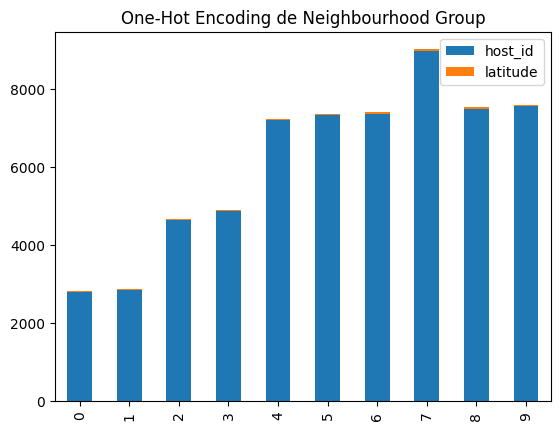

In [14]:
df_encoded.iloc[:, 1:6].head(10).plot(kind="bar", stacked=True)
plt.title("One-Hot Encoding de Neighbourhood Group")
plt.show()

Cada categoría de neighbourhood_group se convirtió en una nueva columna con valores 0 o 1. La visualización de este método muestra:

- La cantidad de registros en cada grupo de vecindario.

- Un claro desequilibrio si algunos vecindarios tienen más alojamientos que otros.

2 - Target Encoding (Sustituir categorías por su valor promedio en la variable objetivo)
Si tienes una variable objetivo price, puedes usar el promedio por categoría:

In [15]:
df['neighbourhood_encoded'] = df.groupby('neighbourhood')['price'].transform('mean')

Esto reemplaza cada barrio (neighbourhood) con el valor promedio de price en ese barrio.

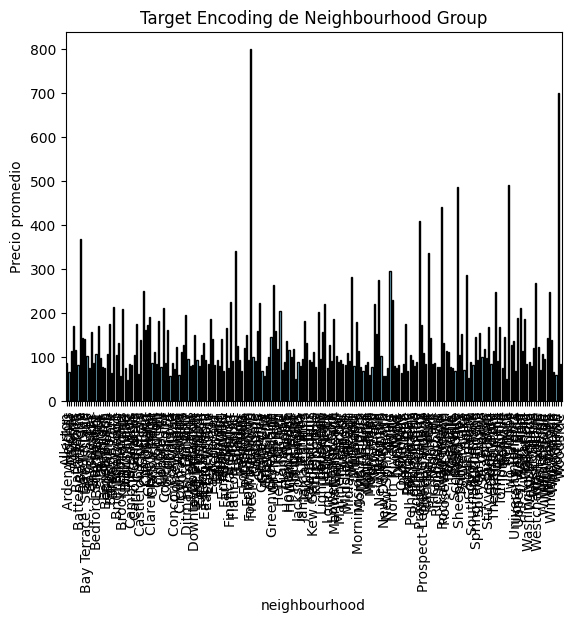

In [16]:
df.groupby('neighbourhood')['neighbourhood_encoded'].mean().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Target Encoding de Neighbourhood Group")
plt.ylabel("Precio promedio")
plt.show()

Filtramos los barrios mas representativos.

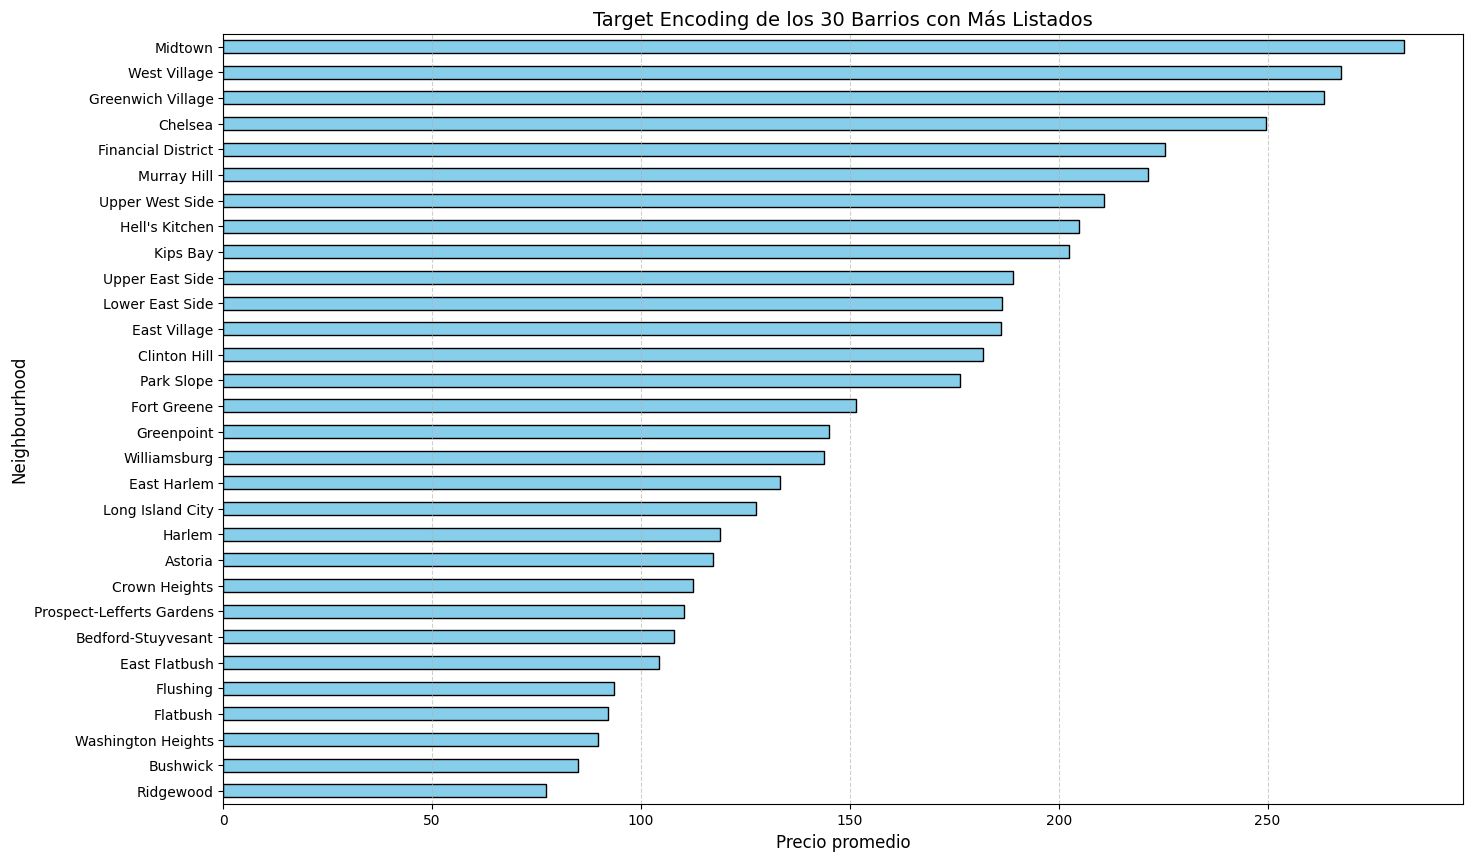

In [17]:
# Filtrar los barrios con más listados para evitar sobrecarga visual
top_neighbourhoods = df['neighbourhood'].value_counts().head(30).index  # Solo los 30 más populares
df_top = df[df['neighbourhood'].isin(top_neighbourhoods)]

# Crear figura más ancha y usar gráfico horizontal
fig, ax = plt.subplots(figsize=(16, 10))
df_top.groupby('neighbourhood')['neighbourhood_encoded'].mean().sort_values().plot(kind="barh", ax=ax, color="skyblue", edgecolor="black")

# Ajustes para mejorar legibilidad
plt.title("Target Encoding de los 30 Barrios con Más Listados", fontsize=14)
plt.xlabel("Precio promedio", fontsize=12)
plt.ylabel("Neighbourhood", fontsize=12)
plt.grid(axis='x', linestyle="--", alpha=0.6)

plt.show()

Este método asigna el precio promedio a cada barrio. El gráfico de barras resultante muestra:
- Diferencias en precios por vecindario, lo que puede ser útil para el análisis de tendencias.
- Vecindarios con precios más altos pueden representar áreas más exclusivas.

3 - Frequency Encoding (Codificación basada en la frecuencia de cada categoría)
Sustituimos cada categoría por la cantidad de veces que aparece en el dataset:

In [18]:
freq_encoding = df['neighbourhood'].value_counts().to_dict()
df['neighbourhood_freq_encoded'] = df['neighbourhood'].map(freq_encoding)

Ahora 'neighbourhood_freq_encoded' contiene la frecuencia de aparición de cada barrio.

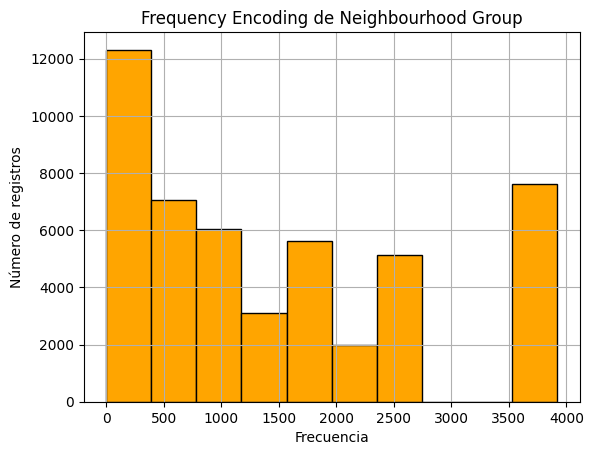

In [19]:
df['neighbourhood_freq_encoded'].hist(bins=10, color='orange', edgecolor='black')
plt.title("Frequency Encoding de Neighbourhood Group")
plt.xlabel("Frecuencia")
plt.ylabel("Número de registros")
plt.show()

En este gráfico de histograma, cada vecindario se sustituye por su frecuencia de aparición:

- Vecindarios con más alojamientos tendrán valores más altos en la transformación.

- Ayuda a ver qué zonas tienen más oferta en el mercado.

4 - Label Encoding (Asignar valores numéricos a categorías)
Este método asigna números enteros únicos a cada categoría, útil para modelos como árboles de decisión:

In [20]:
label_encoder = LabelEncoder()
df['room_type_encoded'] = label_encoder.fit_transform(df['room_type'])

Cada tipo de habitación (room_type) se transforma en un número (0, 1, 2...).

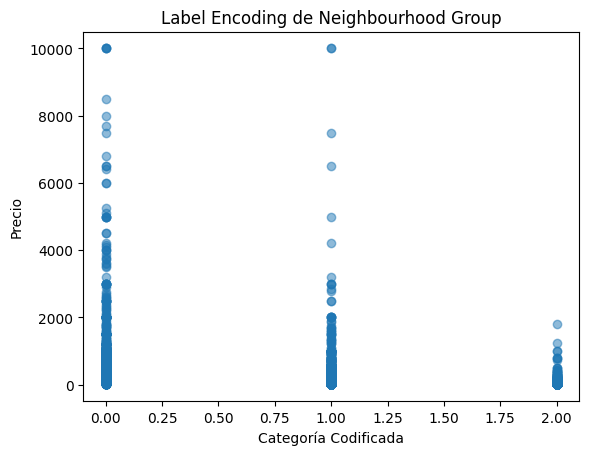

In [21]:
plt.scatter(df['room_type_encoded'], df['price'], alpha=0.5)
plt.title("Label Encoding de Neighbourhood Group")
plt.xlabel("Categoría Codificada")
plt.ylabel("Precio")
plt.show()

El gráfico de dispersión que generaste muestra la relación entre el precio y los valores numéricos asignados por el Label Encoding:

- Al estar categorizado como números enteros, el orden de las categorías puede no ser relevante.

- Si la relación entre la variable codificada y el precio es muy dispersa, puede que Label Encoding no sea la mejor opción.

## 2.Valores faltantes e imputación
- Revisar porcentaje de valores faltantes por columna así como filas.

- Gráficas que muestren patrones en los datos faltantes.

- Imputar en caso necesario (KnnImputer, most common, media, mediana...).




Paso 1: Revisar valores faltantes
Antes de imputar, es fundamental conocer la cantidad de valores faltantes en nuestro dataset.

In [22]:
# Ver porcentaje de valores faltantes por columna
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

# Ver porcentaje de filas con valores faltantes
missing_rows = df.isnull().sum(axis=1)
print(f"Porcentaje de filas con al menos un valor faltante: {missing_rows.value_counts(normalize=True) * 100}")

id                                 0.000000
name                               0.032731
host_id                            0.000000
host_name                          0.042959
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.560920
reviews_per_month                 20.560920
calculated_host_listings_count     0.000000
availability_365                   0.000000
LOG_PRICE                          0.000000
neighbourhood_encoded              0.000000
neighbourhood_freq_encoded         0.000000
room_type_encoded                  0.000000
dtype: float64
Porcentaje de filas con al menos un valor faltante: 0    79.394076
2    20.530235
1     0.045005
3     0.

Paso 2: Visualizar patrones en los datos faltantes
Podemos usar missingno para ver si hay patrones claros en la distribución de los valores faltantes:

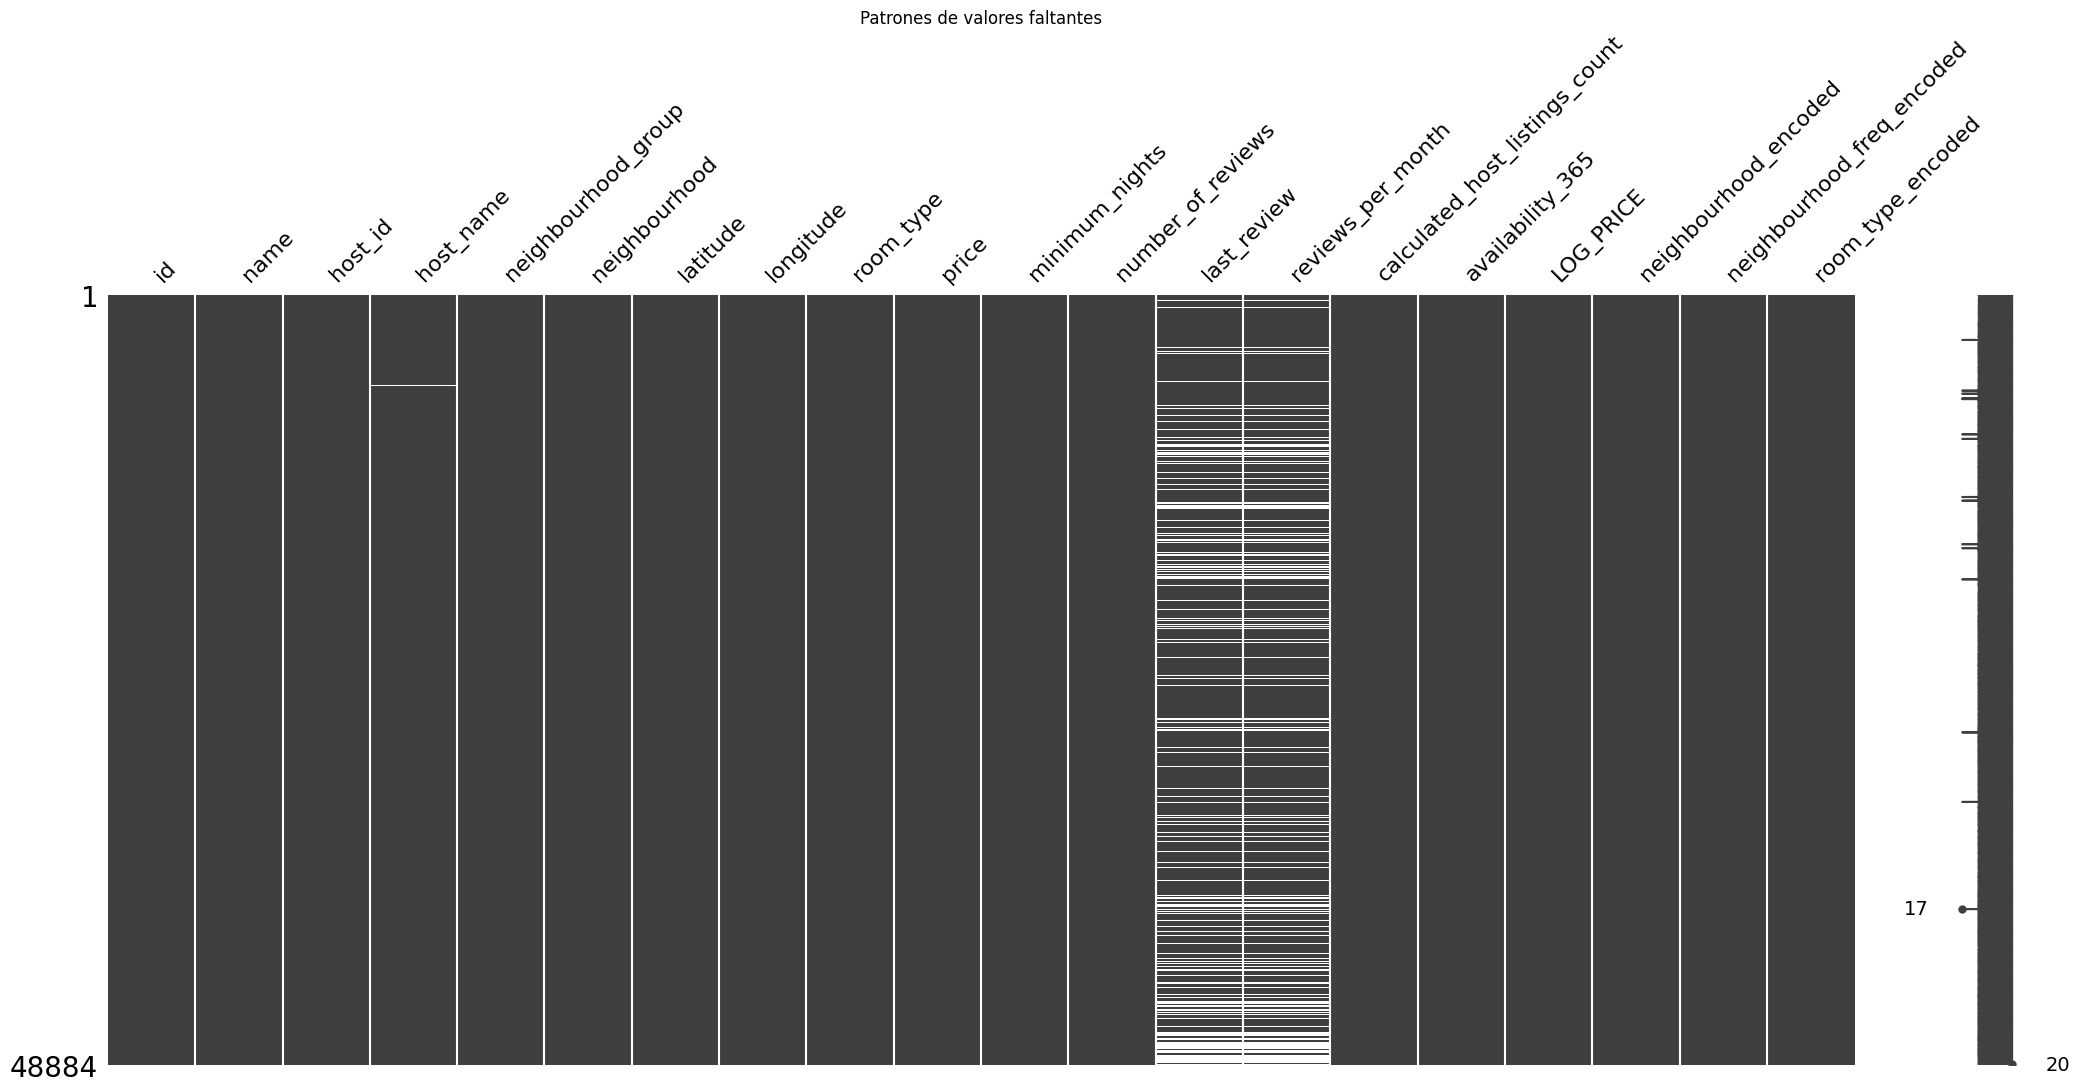

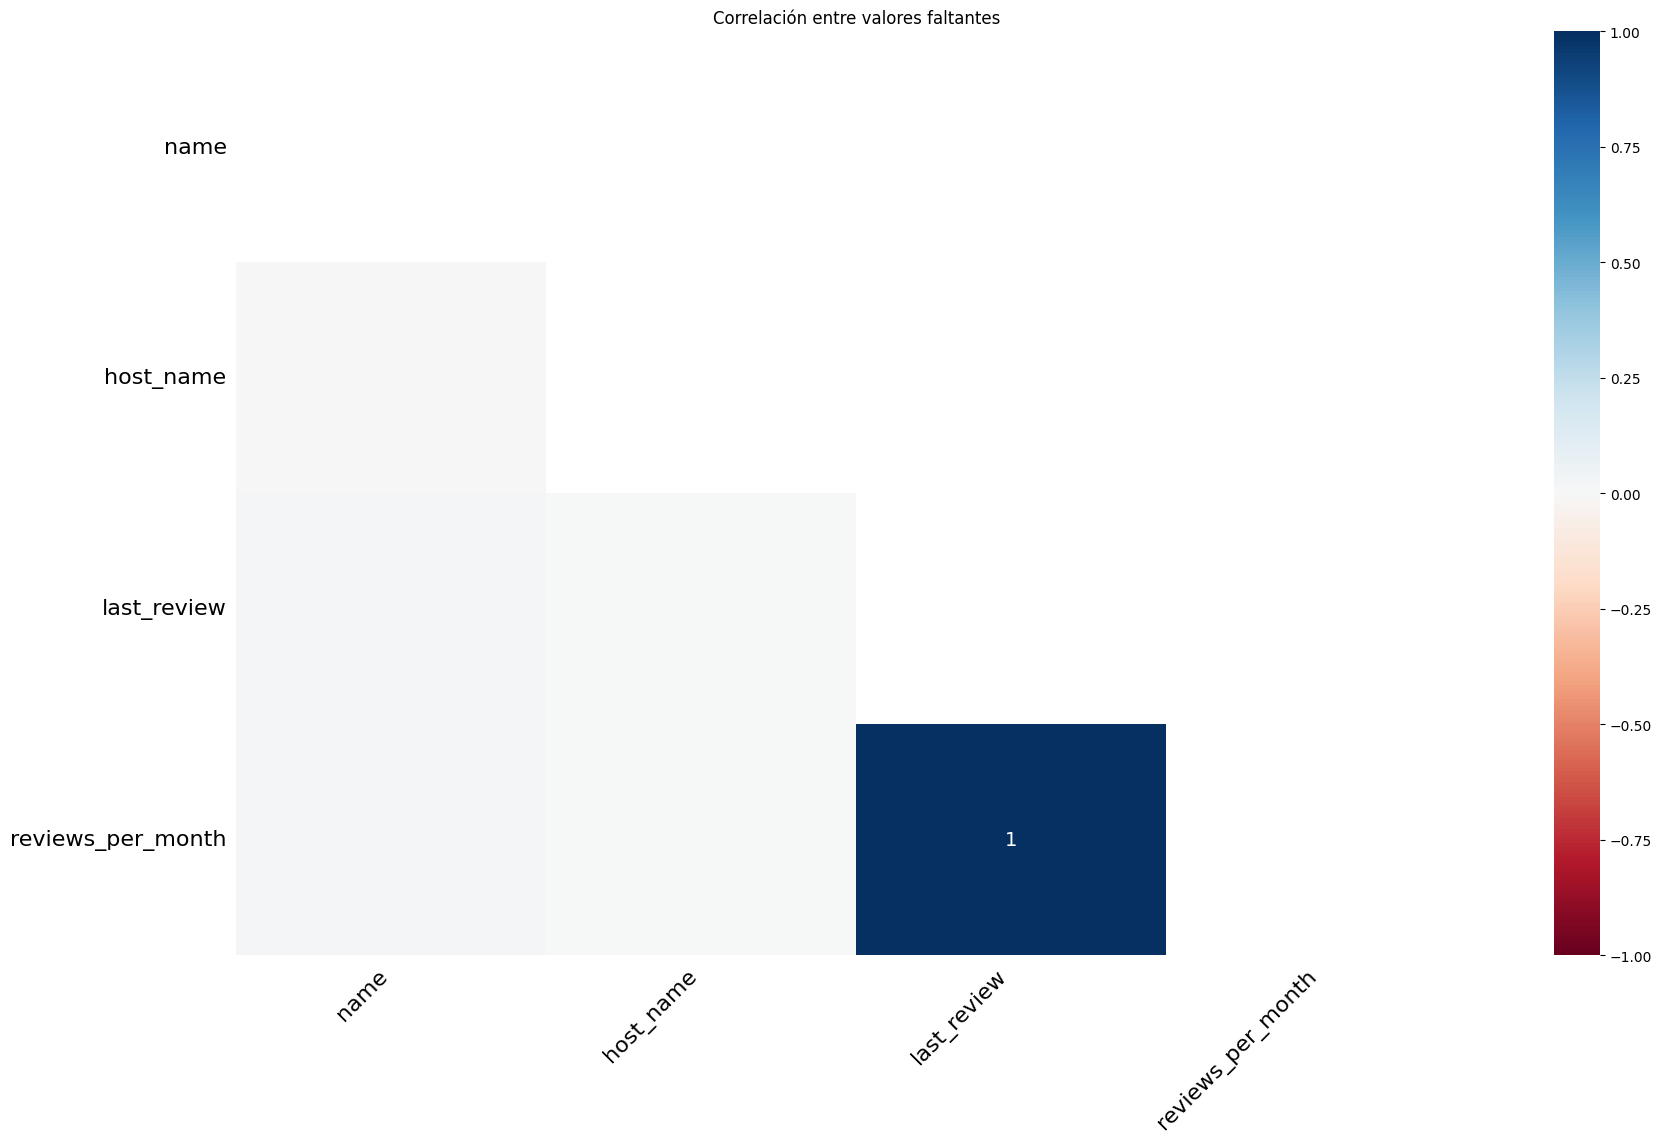

In [23]:
# Mapa de valores faltantes
msno.matrix(df)  # Visualización de valores nulos
plt.title("Patrones de valores faltantes")
plt.show()

# Mapa de correlaciones entre valores faltantes
msno.heatmap(df)  # Relación entre valores nulos
plt.title("Correlación entre valores faltantes")
plt.show()

Interpretación de los gráficos:

Mapa de valores faltantes (matrix): Nos dice qué partes del dataset tienen valores nulos y si hay patrones claros de pérdida de datos.

Mapa de correlaciones (heatmap): Muestra si hay variables con patrones similares de valores faltantes. Esto ayuda a decidir estrategias de imputación.

Paso 3: Imputación de valores faltantes
Dependiendo de la naturaleza de los datos, podemos aplicar diferentes métodos:

1. Imputación con la media (para datos numéricos)

In [24]:
# Identificar columnas numéricas con valores faltantes
num_cols_with_nan = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).isnull().sum() > 0]

# Aplicar imputación con la media en esas columnas
df[num_cols_with_nan] = df[num_cols_with_nan].apply(lambda col: col.fillna(col.mean()))

# Confirmar que los valores faltantes fueron imputados correctamente
print(df[num_cols_with_nan].isnull().sum())

reviews_per_month    0
dtype: int64


Ninguna columna numérica tiene valores faltantes, por lo que no es necesario aplicar la imputación con la media.

2. Imputación con la mediana (para datos numéricos con distribución sesgada)

In [25]:
# Identificar columnas numéricas con valores faltantes
num_cols_with_nan = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).isnull().sum() > 0]

# Aplicar imputación con la mediana en esas columnas
df[num_cols_with_nan] = df[num_cols_with_nan].apply(lambda col: col.fillna(col.median()))

# Confirmar que los valores faltantes fueron imputados correctamente
print(df[num_cols_with_nan].isnull().sum())

Series([], dtype: float64)


Ninguna columna numérica tiene valores faltantes, por lo que no es necesario aplicar la imputación con la mediana.

3. Imputación con moda (para datos categóricos)

In [26]:
# Identificar columnas categóricas con valores faltantes
cat_cols_with_nan = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().sum() > 0]

# Aplicar imputación con la moda en esas columnas
df[cat_cols_with_nan] = df[cat_cols_with_nan].apply(lambda col: col.fillna(col.mode()[0]))

# Confirmar que los valores faltantes fueron imputados correctamente
print(df[cat_cols_with_nan].isnull().sum())

name           0
host_name      0
last_review    0
dtype: int64


Este resultado indica que las columnas categóricas no tienen valores faltantes, por lo que no es necesario aplicar la imputación con la moda.

4. Imputación con KNNImputer (para valores con relación a otras columnas)
Si los datos tienen relaciones con otras variables, el algoritmo KNN puede ser útil:

In [27]:
# Identificar columnas numéricas con valores faltantes
num_cols_with_nan = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).isnull().sum() > 0]

if len(num_cols_with_nan) > 0:  # Solo aplicar si hay columnas con NaN
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols_with_nan] = imputer.fit_transform(df[num_cols_with_nan])
    print("Imputación completada. Valores faltantes restantes:")
    print(df[num_cols_with_nan].isnull().sum())
else:
    print("No hay valores faltantes en columnas numéricas. No se aplicó imputación con KNNImputer.")

No hay valores faltantes en columnas numéricas. No se aplicó imputación con KNNImputer.


## 3.Partición del dataset en conjunto de entrenamiento y test

1 - Definir variables predictoras y objetivo
Debemos elegir las columnas que usaremos como features (X) y cuál será nuestro target (Y). Supongamos que queremos predecir price con el resto de variables:

In [28]:
# Definir X (variables predictoras) e Y (variable objetivo)
X = df.drop(['LOG_PRICE','price'],axis=1) # Elimina 'price' porque es lo que queremos predecir
y = df['LOG_PRICE']

#Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%), asegurando que la partición sea aleatoria pero reproducible:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2 - Aplicar la partición del dataset
Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%), asegurando que la partición sea aleatoria pero reproducible:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Explicación:

test_size=0.2: Indica que el 20% de los datos se usará para test.

random_state=42: Fijar una semilla garantiza que la partición sea siempre la misma.

3 - Validar la distribución de los datos
Podemos verificar cuántos registros hay en cada conjunto con:

In [30]:
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

Tamaño del conjunto de entrenamiento: (39107, 18)
Tamaño del conjunto de prueba: (9777, 18)


## 4 – Visualización de distribución de precios
Podemos hacer un histograma para comprobar si la distribución de precios en el conjunto de prueba es similar al de entrenamiento:

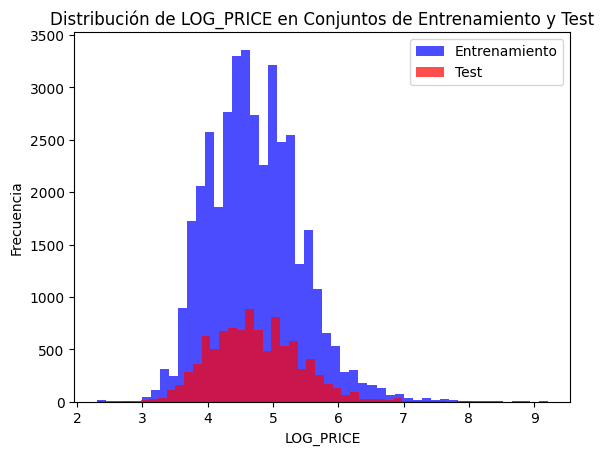

In [31]:
plt.hist(y_train, bins=50, alpha=0.7, label="Entrenamiento", color="blue")
plt.hist(y_test, bins=50, alpha=0.7, label="Test", color="red")
plt.legend()
plt.xlabel("LOG_PRICE")
plt.ylabel("Frecuencia")
plt.title("Distribución de LOG_PRICE en Conjuntos de Entrenamiento y Test")
plt.show()

4.(Para regresión) Observaciones influyentes.

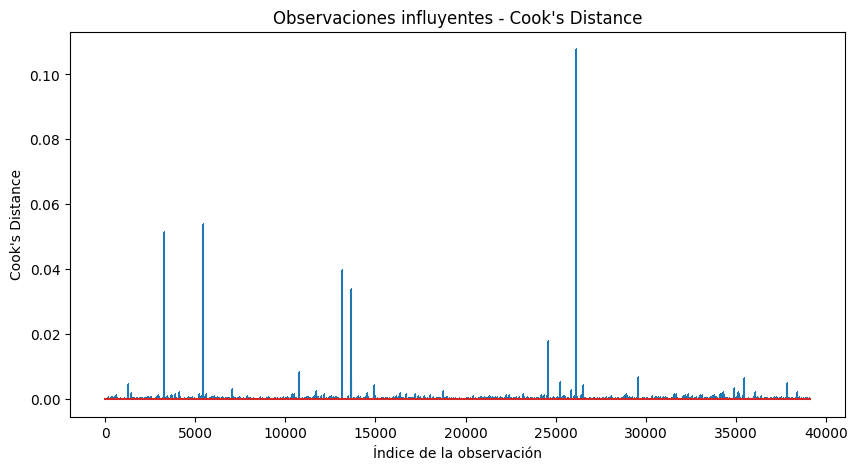

In [32]:
# Crear copia de X_train para evitar cambios no deseados
X_train_encoded = X_train.copy()

# Convertir solo columnas categóricas a números con LabelEncoder
for col in X_train_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])

# Agregar constante para la regresión
X_train_const = sm.add_constant(X_train_encoded)

# Ajustar modelo de regresión lineal
model = sm.OLS(y_train, X_train_const).fit()

# Obtener Cook's Distance
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

# Visualización de Cook's Distance
plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel("Índice de la observación")
plt.ylabel("Cook's Distance")
plt.title("Observaciones influyentes - Cook's Distance")
plt.show()

Interpretación Histograma de LOG_PRICE:

El histograma muestra la distribución de precios después de aplicar una transformación logarítmica (LOG_PRICE).

La mayoría de los valores parecen concentrarse en una zona específica, lo que indica que hay un rango predominante de precios.

Si la distribución se asemeja a una curva normal, la transformación ha ayudado a estabilizar la varianza y reducir la influencia de valores extremos.

Si hay una cola larga hacia la derecha (sesgo positivo), todavía existen alojamientos con precios altos, aunque menos extremos que antes de la transformación.

Conclusión: Si la distribución es más simétrica que el precio original (PRICE), la transformación ha sido efectiva para preparar el dato en modelos de regresión.

Si el histograma muestra una distribución más simétrica, entonces LOG_PRICE es una mejor opción para modelar la regresión.

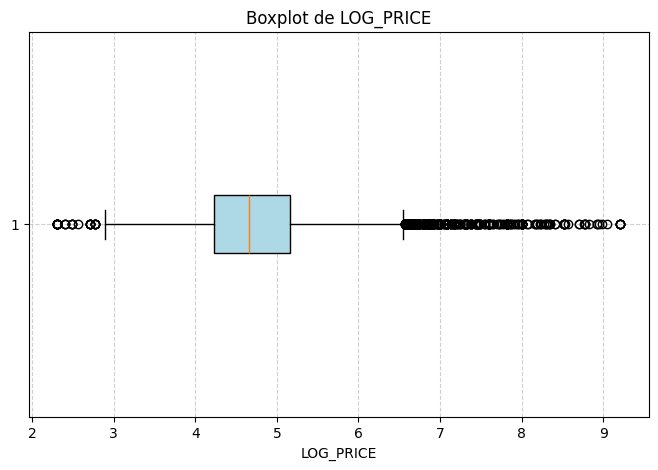

In [33]:
# Crear un boxplot de LOG_PRICE
plt.figure(figsize=(8, 5))
plt.boxplot(df['LOG_PRICE'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot de LOG_PRICE")
plt.xlabel("LOG_PRICE")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretación Boxplot de LOG_PRICE:

El boxplot nos ayuda a visualizar la dispersión de los datos y la presencia de valores atípicos.

La línea central representa la mediana, lo que nos indica el punto medio de los precios transformados.

Los bigotes muestran la variabilidad de la mayoría de los datos, pero los puntos fuera de los bigotes son outliers (precios que están significativamente alejados del resto).

Si la dispersión se ha reducido respecto al boxplot original de PRICE, la transformación ha sido útil para manejar valores extremos.

Conclusión: Este gráfico nos confirma si aún quedan valores que pueden afectar la regresión. Si hay demasiados puntos alejados, podríamos considerar un tratamiento adicional, como recortar valores extremos.

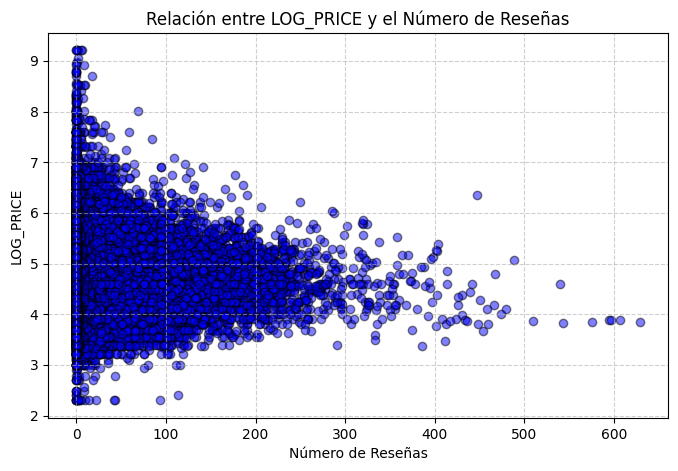

In [34]:
# Crear scatter plot de LOG_PRICE vs. number_of_reviews
plt.figure(figsize=(8, 5))
plt.scatter(df['number_of_reviews'], df['LOG_PRICE'], alpha=0.5, color='blue', edgecolors='black')
plt.xlabel("Número de Reseñas")
plt.ylabel("LOG_PRICE")
plt.title("Relación entre LOG_PRICE y el Número de Reseñas")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Interpretación Scatter plot de LOG_PRICE:

Si los puntos tienen una tendencia ascendente, puede indicar que los alojamientos con más reseñas tienden a tener un precio más alto.

Si no hay un patrón claro, puede significar que number_of_reviews no influye directamente en el precio.

Outliers visibles podrían indicar alojamientos con precios anómalos o una cantidad de reseñas excepcionalmente alta o baja.

Paso 1: Calcular Cook's Distance
Este método nos ayuda a identificar observaciones que pueden estar afectando demasiado el modelo.

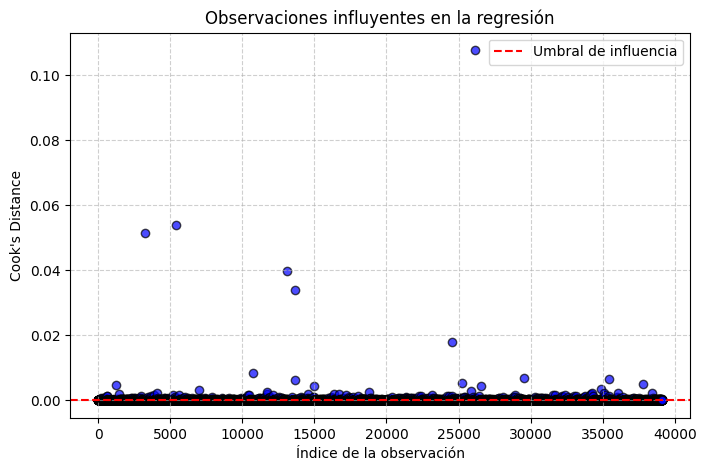

Observaciones influyentes detectadas: 1704


In [35]:
#Selección de variables predictoras y objetivo
X = df.drop(columns=['LOG_PRICE', 'price'])  # Eliminamos la variable objetivo
y = df['LOG_PRICE']

#Transformar variables categóricas a numéricas usando LabelEncoder
categorical_cols = ['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']
df_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # Convertimos a string antes de codificar

#Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

#Agregar constante a X_train para la regresión
X_train_const = sm.add_constant(X_train)

#Ajustar el modelo de regresión lineal
model = sm.OLS(y_train, X_train_const).fit()

#Obtener Cook's Distance para detectar observaciones influyentes
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance

#Definir punto de corte basado en el tamaño del conjunto de entrenamiento
pto_corte = 4 / len(X_train)
observaciones_influyentes = np.where(cooks_d > pto_corte)[0]  # Índices de valores influyentes

#Visualización de Cook's Distance
plt.figure(figsize=(8, 5))
plt.scatter(np.arange(len(cooks_d)), cooks_d, alpha=0.7, color="blue", edgecolors="black")
plt.axhline(y=pto_corte, color='red', linestyle='--', label="Umbral de influencia")
plt.xlabel("Índice de la observación")
plt.ylabel("Cook's Distance")
plt.title("Observaciones influyentes en la regresión")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

#Mostrar cantidad de observaciones influyentes detectadas
print(f"Observaciones influyentes detectadas: {len(observaciones_influyentes)}")

Calculamos el porcentaje de viviendas influyentes. Extraemos los índices de las viviendas con valores altos de Cook's Distance.

In [36]:
# Obtener los índices de viviendas influyentes
idx_viviendas_influyentes = np.where(cooks_d > pto_corte)[0]

# Calcular el porcentaje de viviendas afectadas
porcentaje_viviendas_influyentes = (len(idx_viviendas_influyentes) / len(df)) * 100

# Mostrar el resultado
print(f'Porcentaje de viviendas a desestimar: {porcentaje_viviendas_influyentes:.2f}%')

Porcentaje de viviendas a desestimar: 3.49%


In [37]:
# Obtener un array con los índices de viviendas influyentes
idx_viviendas_influyentes

array([   61,    65,   107, ..., 39071, 39074, 39082], shape=(1704,))

Creamos un nuevo conjunto de entrenamiento eliminando las viviendas mas influyentes.

In [38]:
X_train.index[idx_viviendas_influyentes]

Index([40299, 40469, 16596, 19713, 18400, 32041, 41913, 32913, 27422, 32810,
       ...
       25947, 46710, 44031, 22299, 45162,  2027, 48566, 11394,  1899, 41445],
      dtype='int64', length=1704)

In [39]:
X_train1 = X_train.loc[~X_train.index.isin(X_train.index[idx_viviendas_influyentes]),:]

In [40]:
y_train1 = y_train.loc[~X_train.index.isin(X_train.index[idx_viviendas_influyentes])]

In [41]:
print(f"Total de viviendas eliminadas: {len(idx_viviendas_influyentes)}")
print(f"Tamaño original: {X_train.shape[0]}, Tamaño filtrado: {X_train1.shape[0]}")

Total de viviendas eliminadas: 1704
Tamaño original: 39107, Tamaño filtrado: 37403


## 5.Extracción de características
A partir de las características originales obtener más datos, por ejemplo una columna que indique si era festivo/fin de semana en una daterminada fecha.

In [ ]:
#Definir la columna de fecha 
df['last_review'] = pd.to_datetime(df['last_review'])  # Convertir a formato datetime

#Crear columna que indica si es fin de semana
df['es_fin_de_semana'] = df['last_review'].dt.dayofweek.isin([5, 6])  # 5=Sábado, 6=Domingo

#Crear columna que indica si era festivo en EE.UU.
us_holidays = holidays.US()  # Festivos en EE.UU.
df['es_festivo'] = df['last_review'].apply(lambda x: x in us_holidays)

#Ver los primeros registros
print(df[['last_review', 'es_fin_de_semana', 'es_festivo']].head())

  last_review  es_fin_de_semana  es_festivo
0  2018-10-19             False       False
1  2019-05-21             False       False
2  2019-06-23              True       False
3  2019-07-05             False       False
4  2018-11-19             False       False


In [ ]:
#Entrenar un modelo XGBoost para evaluar importancia de características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)

#Creamos un df de importancias de características
dict_data = {'Feature':X_train.columns, 'Importancia':xgb_model.feature_importances_*100}
df_imp = pd.DataFrame(dict_data)

#Ordenar descendentemente por importancia
df_imp.sort_values(by='Importancia', ascending=False, inplace=True)

#Nombres de columnas con una importancia mayor igual a un 1%
df_imp[df_imp['Importancia']>=1]

,Feature,Importancia
8,room_type,74.810371
15,neighbourhood_encoded,10.251207
14,availability_365,1.929315
9,minimum_nights,1.907527
13,calculated_host_listings_count,1.635901
10,number_of_reviews,1.322970
7,longitude,1.077328


In [ ]:
#Filtrar solo las características con importancia >= 1%
features_seleccionadas = df_imp[df_imp['Importancia'] >= 1]['Feature'].tolist()

#Crear nuevo conjunto de datos con solo las características importantes
X_train_filtrado = X_train[features_seleccionadas]
X_test_filtrado = X_test[features_seleccionadas]  # Si tienes conjunto de prueba

print(f"Número de características eliminadas: {X_train.shape[1] - X_train_filtrado.shape[1]}")
print(f"Número de características finales: {X_train_filtrado.shape[1]}")

Número de características eliminadas: 11
Número de características finales: 7


In [ ]:
#Calcular la matriz de correlación
matriz_corr = X_train1.corr()

#Calcular el VIF para cada variable en X_train1
vif = pd.Series([variance_inflation_factor(matriz_corr.values, i) 
                 for i in range(matriz_corr.shape[1])], 
                index=X_train1.columns)

# Mostrar los resultados
print(vif)

id                                13.403698
name                               1.040953
host_id                            5.759453
host_name                          1.018587
neighbourhood_group                3.455936
neighbourhood                      1.609855
latitude                           2.180012
longitude                          7.031777
room_type                               inf
minimum_nights                     1.546019
number_of_reviews                 11.953236
last_review                        4.309014
reviews_per_month                 12.073751
calculated_host_listings_count     1.746320
availability_365                   2.490106
neighbourhood_encoded              8.628109
neighbourhood_freq_encoded         1.887362
room_type_encoded                       inf
dtype: float64


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Detecta variables con alta multicolinealidad, que pueden afectar el rendimiento del modelo. Si una variable tiene VIF > 5, se recomienda eliminarla, ya que está altamente correlacionada con otras. Esto nos permite optimizar el dataset, reduciendo redundancias y mejorando la estabilidad del modelo.

In [54]:
vif = pd.Series([variance_inflation_factor(X_train1.corr().values, i) for i in range(X_train1.corr().shape[1])], index=X_train1.columns)
vif

id                                13.403698
name                               1.040953
host_id                            5.759453
host_name                          1.018587
neighbourhood_group                3.455936
neighbourhood                      1.609855
latitude                           2.180012
longitude                          7.031777
room_type                               inf
minimum_nights                     1.546019
number_of_reviews                 11.953236
last_review                        4.309014
reviews_per_month                 12.073751
calculated_host_listings_count     1.746320
availability_365                   2.490106
neighbourhood_encoded              8.628109
neighbourhood_freq_encoded         1.887362
room_type_encoded                       inf
dtype: float64

<Axes: >

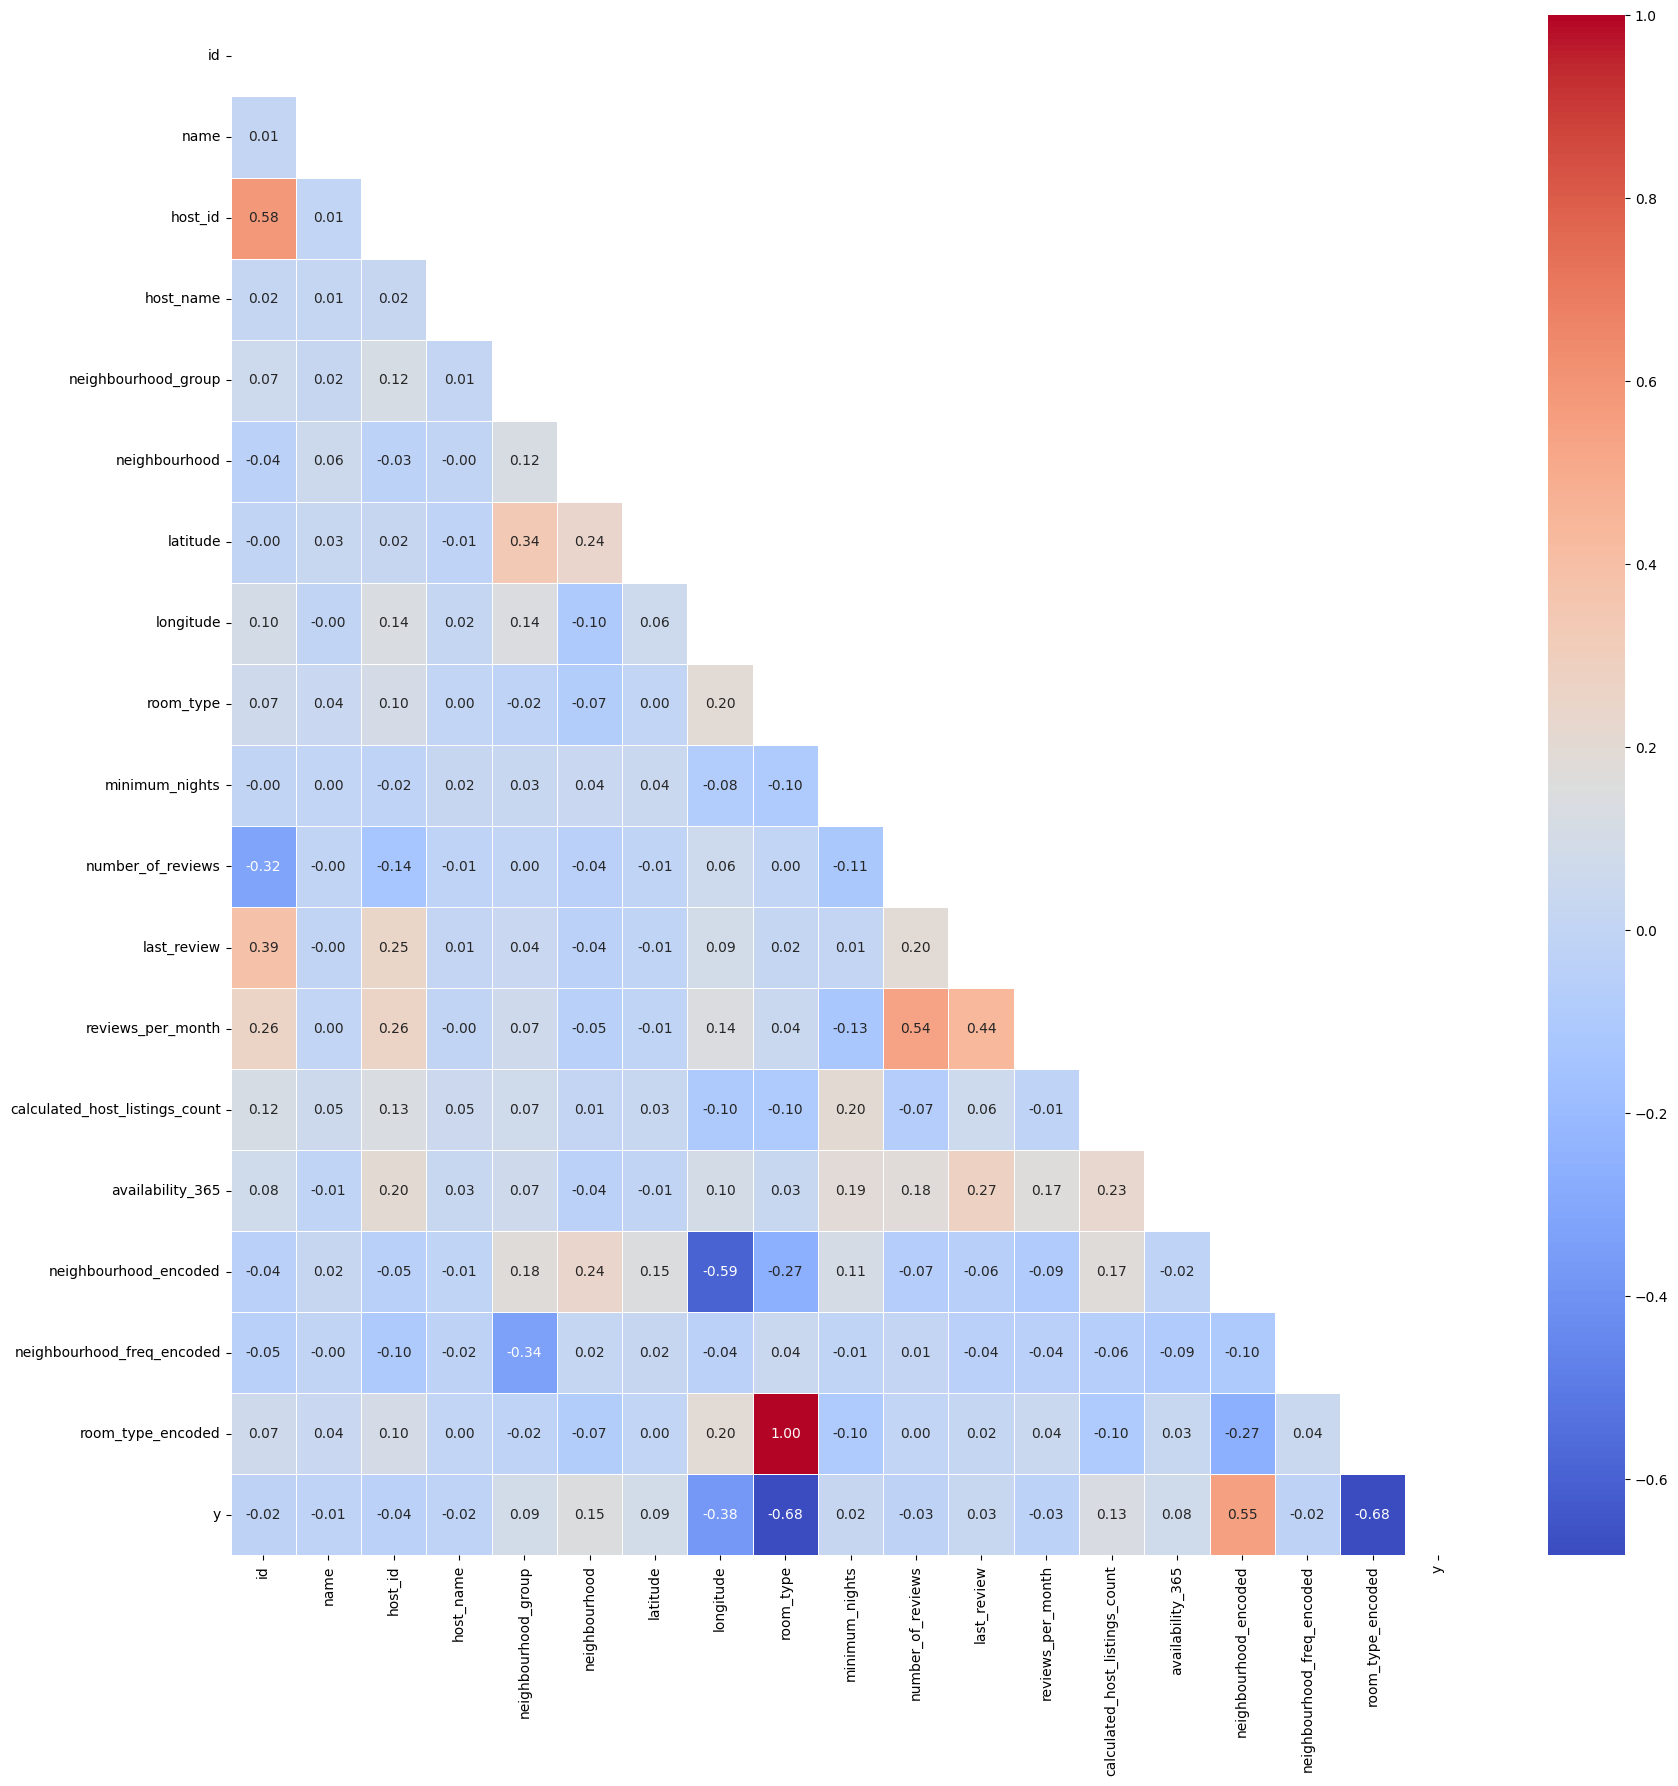

In [47]:
X_corr = X_train1.copy() #Copiamos X_train1 en X_corr. Así evitamos modificar el dataset original
X_corr['y'] = y_train1
corr = X_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')


Mapa de calor para visualizar la correlación entre las variables de X_train1 y y_train1, lo que nos ayuda a detectar relaciones fuertes o redundancias en los datos.

In [61]:
def calcular_vif(df):
    return pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)

# Eliminar iterativamente variables con VIF > 5
X_train_final = X_train2.copy()
X_test_final = X_test2.copy()

while calcular_vif(X_train_final).max() > 5:
    var_a_eliminar = calcular_vif(X_train_final).idxmax()  # Identificar la variable con mayor VIF
    X_train_final.drop(columns=[var_a_eliminar], inplace=True)
    X_test_final.drop(columns=[var_a_eliminar], inplace=True)  # Mantener misma estructura en X_test_final

# Mostrar nuevo listado de VIF después de la limpieza
print("Nuevo VIF después de la limpieza:")
print(calcular_vif(X_train_final))

Nuevo VIF después de la limpieza:
name                              3.556550
host_id                           2.242200
host_name                         3.320818
neighbourhood_group               4.981904
neighbourhood                     3.267170
minimum_nights                    1.347362
number_of_reviews                 2.129935
reviews_per_month                 3.143661
calculated_host_listings_count    1.173331
availability_365                  2.040691
neighbourhood_freq_encoded        2.231616
room_type_encoded                 1.879484
dtype: float64


## 7.Escalado de las características
Existen múltiples técnicas de escalado, por ejemplo:

MinxmaxScaler (0-1): Se conoce como normalizar y sería inidicado cuando creemos cononer los valores mínimos y máximos de las características.

standardScaler (media 0 std 1): Se conoce como estandarizar y sería inidicado cuando creemos que nustras variables siguen una distibución normal.

In [64]:
# Inicializar los escaladores
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Aplicar MinMaxScaler (normalización 0-1)
X_train_minmax = minmax_scaler.fit_transform(X_train2)
X_test_minmax = minmax_scaler.transform(X_test2)

# Aplicar StandardScaler (media 0, desviación estándar 1)
X_train_standard = standard_scaler.fit_transform(X_train2)
X_test_standard = standard_scaler.transform(X_test2)

# Verificar tamaños
print(f"X_train_minmax: {X_train_minmax.shape}, X_train_standard: {X_train_standard.shape}")
print(f"X_test_minmax: {X_test_minmax.shape}, X_test_standard: {X_test_standard.shape}")

X_train_minmax: (37403, 12), X_train_standard: (37403, 12)
X_test_minmax: (9777, 12), X_test_standard: (9777, 12)


In [65]:
# Inicializar el escalador
scaler = MinMaxScaler()

# Aplicar la transformación y conservar nombres e índices
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns, index=X_train2.index)
X_test_sc = pd.DataFrame(scaler.transform(X_test2), columns=X_test2.columns, index=X_test2.index)
X_test_sc

,name,host_id,host_name,neighbourhood_group,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_freq_encoded,room_type_encoded
41320,0.702879,0.865176,0.900070,0.50,0.154545,0.022044,0.006359,0.037267,0.009202,0.079452,0.283818,0.5
22079,0.490134,0.417308,0.590234,0.50,0.277273,0.002004,0.174881,0.192547,0.009202,0.649315,0.284839,0.5
18778,0.394149,0.181184,0.504455,0.25,0.972727,0.058116,0.015898,0.014811,0.021472,0.265753,1.000000,0.0
25494,0.835383,0.027090,0.651642,0.50,0.936364,0.000000,0.001590,0.001433,0.000000,0.000000,0.229199,0.5
44319,0.140668,0.896345,0.228774,0.50,0.427273,0.006012,0.000000,0.065128,0.003067,1.000000,0.678152,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
24329,0.342472,0.501972,0.234888,0.50,0.522727,0.012024,0.022258,0.029145,0.000000,0.175342,0.030628,0.5
40905,0.129977,0.042541,0.350454,0.25,0.127273,0.002004,0.000000,0.065128,0.003067,0.000000,0.628127,0.5
31179,0.601403,0.664642,0.797781,0.25,0.722727,0.006012,0.092210,0.181080,0.000000,0.213699,0.136294,0.0
40872,0.067338,0.785855,0.160290,0.25,0.127273,0.002004,0.023847,0.133779,0.021472,0.942466,0.628127,0.5


Interpretación por variable

room_type → Al ser una variable categórica transformada en numérica nos da un resultado no concluyente ya que da valores entre 0 y 1 dependiendo del tipo de habitación.

minimum_nights → Tiene valores pequeños, con algunos cercanos a 0. Esto podría indicar que la mayoría de los alojamientos tienen requisitos de estancia mínima baja.

number_of_reviews → Hay mucha variabilidad. Algunos registros tienen 0 reseñas, mientras que otros pueden estar cerca de 0.17 (su máximo escalado).

calculated_host_listings_count → Muchos valores están cerca de 0, lo que sugiere que la mayoría de los anfitriones tienen pocos listados en la plataforma.

availability_365 → Presenta una gran dispersión, con valores que van desde 0 hasta 1, indicando que algunos alojamientos están disponibles todo el año, mientras que otros tienen una disponibilidad mucho menor.